In [1]:
using CSV
using DataFrames

In [10]:
include("general_create_model.jl")
include("structures.jl")
include("visualization_functions.jl")
include("auxiliary_functions.jl")

bottleneck_metrics (generic function with 1 method)

In [3]:
#NEW DATA:
newdata = CSV.read("data/input_data/input_data_30-10-2024_seed_42.csv", DataFrame; delim=';')

Row,Order,Job,Path,Arrival,Resource_idx,Resource_2,Resource_3,Resource_4,Resource_5,Resource_6,Resource_7,job_WC,Duration,MinDelivery,Slack,Duedate
,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Int64
1,1,1,9,1,3,0.0,5.98325,0.0,0.0,0.0,0.0,5.98325,2,6,3.0,10
2,1,2,9,1,5,0.0,0.0,0.0,3.99601,0.0,0.0,3.99601,2,6,3.0,10
3,1,3,9,1,7,0.0,0.0,0.0,0.0,0.0,0.577784,0.577784,2,6,3.0,10
4,2,4,6,1,2,8.1297,0.0,0.0,0.0,0.0,0.0,8.1297,4,7,3.05,12
5,2,5,6,1,3,0.0,4.45847,0.0,0.0,0.0,0.0,4.45847,1,7,3.05,12
6,2,6,6,1,7,0.0,0.0,0.0,0.0,0.0,0.702172,0.702172,2,7,3.05,12
7,3,7,6,1,2,1.79666,0.0,0.0,0.0,0.0,0.0,1.79666,1,5,2.05,9
8,3,8,6,1,3,0.0,5.01364,0.0,0.0,0.0,0.0,5.01364,2,5,2.05,9
9,3,9,6,1,7,0.0,0.0,0.0,0.0,0.0,1.20562,1.20562,2,5,2.05,9


In [4]:
newdata = newdata[1:103,:]

Row,Order,Job,Path,Arrival,Resource_idx,Resource_2,Resource_3,Resource_4,Resource_5,Resource_6,Resource_7,job_WC,Duration,MinDelivery,Slack,Duedate
,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Int64
1,1,1,9,1,3,0.0,5.98325,0.0,0.0,0.0,0.0,5.98325,2,6,3.0,10
2,1,2,9,1,5,0.0,0.0,0.0,3.99601,0.0,0.0,3.99601,2,6,3.0,10
3,1,3,9,1,7,0.0,0.0,0.0,0.0,0.0,0.577784,0.577784,2,6,3.0,10
4,2,4,6,1,2,8.1297,0.0,0.0,0.0,0.0,0.0,8.1297,4,7,3.05,12
5,2,5,6,1,3,0.0,4.45847,0.0,0.0,0.0,0.0,4.45847,1,7,3.05,12
6,2,6,6,1,7,0.0,0.0,0.0,0.0,0.0,0.702172,0.702172,2,7,3.05,12
7,3,7,6,1,2,1.79666,0.0,0.0,0.0,0.0,0.0,1.79666,1,5,2.05,9
8,3,8,6,1,3,0.0,5.01364,0.0,0.0,0.0,0.0,5.01364,2,5,2.05,9
9,3,9,6,1,7,0.0,0.0,0.0,0.0,0.0,1.20562,1.20562,2,5,2.05,9


In [5]:
I = length(newdata.Job)
K = maximum(newdata.Resource_idx)-1
capacity = [6, 6, 6, 8, 9, 2]
P = newdata.Duration
D = newdata.Duedate
A = newdata.Arrival
T = 130 #Number of time steps
M = 10000; 
WC = Matrix(newdata[:,6:11])
OA = newdata.Arrival;
MinDelivery = newdata.MinDelivery
N_order = maximum(newdata.Order)

29

In [40]:
#ROLLING HORIZON MAIN LOOP:

#Hard coded variables for dynamic model:
RESCHEDULING_FREQ = 3 #Rescheduling frequency in days
KAPPA = 40 #Number of jobs allowed in job window

#Model parameters:
periodical = true #True if rescheduling is done periodically

#Rescheduling strategies are "free_strategy", "frozen_strategy" or "forward_stragy")
strat = "free_strategy"
@assert(strat in ("free_strategy", "frozen_strategy", "forward_strategy"))

#Timing template: "fixed" or "free"
#Fixed will probably be the only option in final version.
timing_template = "fixed"
@assert(timing_template in ("fixed", "free"))

#Workload distribution: even or free
workload_distribution = "even"
@assert(workload_distribution in ("even", "free"))


#Precedence constraints:
#These are declared in "offline" manner, because it doesn't really affect the scheduling
prec_consts = all_precedence_constraints(newdata)

#ROLLING HORIZON PROCEDURE BY FANG & XI
T_p = 0 #Predictive period, time steps into future for which arrival of jobs can be predicted, or are known here (not used)
T_F = 50 #Final time step
S_j = [i for i in 1:I] #"Set" of all jobs
S_a = Vector{Int64}() #"Set" of available jobs
S_w = Vector{Int64}() #"Set" of jobs in current job window
S_c = Vector{Int64}() #"Set" of completed jobs
S_s = Vector{Int64}() #"Set" of started jobs

job_arrivals = Dict(zip(S_j, A)) #Dictionary, job id => job arrival time (in days)
job_durations = Dict(zip(S_j, P)) #Dictionary, job id => job duration (days)
job_starts = Dict(zip(S_j, [100 for i in 1:I])) #Initialize starting times of jobs to very distant future
job_completed = Dict(zip(S_j, [100 for i in 1:I])) #Initialize complete times of jobs to very distant future
job_due = Dict(zip(S_j, D)) #Dictionary, job id => 

#Data to be saved from each time step:
#Some are for 
#Some are for debugging purposes only, to be deprecated
model_copy = Dict()
starts_T = Dict{Int64, Dict{Int64, Int64}}() #start time of jobs at timestep t
finish_T = Dict{Int64, Dict{Int64, Int64}}() #finish times of jobs at timestep t
resource_load_T = Dict() #load on different resources at timestep t
X_T = Dict()
C_T = Dict()
c_T = Dict()
rauxs = Dict()

println("-------------------------------------------------------------------------------------------------------")
println("DYNAMIC SCHEDULING MODEL, V.V CODE SOLUTIONS AB OY")
println("Model parameters:")
println("Rescheduling strategy: ", strat)
println("Rescheduling frequency: ", RESCHEDULING_FREQ)
println("Rescheduling is periodical: ", periodical)
println("Timing template: ", timing_template)
println("Workload distribution is : ", workload_distribution)
println("Final time step: ", T_F)
println("-------------------------------------------------------------------------------------------------------")

@time for t in 1:T_F
    #Phase 1: Update S_a and S_w
    #All jobs whose arrival time is less or equal than present time + predictive period AND who are not already in sets S_a S_w, S_c, S_s
    available = Vector{Int64}() #Initialize available vector, its emptiness will be checked in Phase 3
    available = sort([i for (i,v) in job_arrivals if v<=t+T_p && i ∉ S_a && i ∉ S_w && i ∉ S_s && i ∉ S_c]) 
    append!(S_a, available) #Move jobs to available jobs
    
    while((length(S_w) < KAPPA) && (length(S_a) > 0)) #Fill the job window till its length is kappa or available jobs run out
         push!(S_w, popfirst!(S_a)) #Push jobs into job window fron available jobs, FIFO-rule is applied
    end

        
    #Phase 2: Update S_w, S_c and S_s. 
    #Move job to "started_jobs", if current timestep is its start time or larger. Start time is defines as first ongoing timestep.
    for job in S_w
        if(job_starts[job] <= t) #HAS TO BE SOFT INEQUALITY
            push!(S_s, job) #Add job to "set" of started jobs
            filter!(e->e≠job,S_w) #Remove job from job window
            job_completed[job] = job_starts[job] + job_durations[job]
        end
    end

    #Move job to "completed jobs", if current timestep is its finish time or larger. Finish time is defined here as: start time + duration.
    for job in S_s
        if (job_starts[job] + job_durations[job]) <= t #if job has finished
            push!(S_c, job) #Add job to "set" of completed jobs
            filter!(e->e≠job,S_s) #Remove job from "set" of started jobs 
            job_completed[job] = job_starts[job] + job_durations[job]
        end
    end

    #Form auxiliary load-arrays. Load information of ongoing jobs are saved here, because those jobs are not in the model anymore after they have 
    #been started. Auxiliary load-arrays are used to constrain capacity overload. More information in auxiliary_functions.jl and create_model.jl.
    raux = R_aux(S_s, t, resource_load_T, K, T, I, RESCHEDULING_FREQ)
    rauxs[t] = raux
    
    #Phase 3: Reschedule jobs (Update start_times)
    #Rescheduling is going to happen, if rescheduling strategy is periodical and its correct time period
    #OR: resc. strat. is event-driven and there has appeared new available jobs in time step
    #OR timestep is 1
    #NOTE: event-driven is DEPRECATED!!!!
    if t == 1 || ((t % RESCHEDULING_FREQ == 0) && periodical) || (!periodical && (length(available) > 0))
        P_w, D_w, A_w, WC_w, OA_w = create_job_window_data(S_w, I, P, D, A, WC, OA)
        
        #Create model for jobs in the job window
        model = create_job_window_model(S_w, P_w, D_w, A_w, WC_w, OA_w, job_starts, capacity, t, raux, prec_consts, workload_distribution, timing_template)
        
        if strat == "frozen_strategy"
            scheduled_jobs = find_scheduled_jobs(S_w, job_starts)
            model = fix_scheduled_jobs(model, scheduled_jobs, job_starts, job_durations)
        elseif strat == "forward_strategy"
            scheduled_jobs = find_scheduled_jobs(S_w, job_starts)
            model = postpone_scheduled_jobs(model, scheduled_jobs, job_starts, job_durations, job_due)
        end
        #If "free_strategy", there is no need for additional constraints
        
        set_silent(model)
        set_optimizer_attribute(model, "mip_rel_gap", 0.05) #Relative gap tolerance, |upper bound-lower bound|/|upper bound|
        optimize!(model)
        #Save models for debugging purposes
        model_copy[t] = model

        if is_solved_and_feasible(model)
            println("feasible")
            start_sw = value.(model[:C]) .- P_w #Set new starting time based on model solution (completion time (Model variable) - duration (Model data))
            for (i, j) in enumerate(S_w)
                job_starts[j] = Int(round(start_sw.data[i])) #Rounding because of numerical inaccuracy
            end
        else
            println("infeasible")
            #Jos malli on nyt mahdoton ratkaista, kaikki työt jäävät aikatauluttamatta
            #Pitäisikö koettaa aikatauluttaa muokattu työikkuna, josta on poistettu jo kerran aikataulutetut työt?
        end
        #Save these variables for debugging purposes
        resource_load_T[t] = ((model[:R]))
        X_T[t] = model[:X]
        C_T[t] = model[:C]
        c_T[t] = model[:c]
    end

    #Updating again S_w, S_c and S_s, after rescheduling. If there is no rescheduling, this shouldnt change anything
    for job in S_w
        if(job_starts[job] <= t) #HAS TO BE SOFT INEQUALITY
            push!(S_s, job) #Add job to "set" of started jobs
            filter!(e->e≠job,S_w) #Remove job from job window
            job_completed[job] = job_starts[job] + job_durations[job]
        end
    end

    for job in S_s
        if (job_starts[job] + job_durations[job]) <= t #if job has finished
            push!(S_c, job) #Add job to "set" of completed jobs
            filter!(e->e≠job,S_s) #Remove job from "set" of started jobs 
            job_completed[job] = job_starts[job] + job_durations[job]
        end
    end

    #Save data for plotting purposes
    starts_T[t] = copy(job_starts)
    finish_T[t] = copy(job_completed)


    #Test printing:
    println("t:", t)
    println("S_a: ", (S_a))
    println("S_w: ", (S_w))
    println("S_s: ", (S_s))
    println("S_c: ", (S_c))
    println("____________________________________________________________________________________________________________")
    flush(stdout)
    
    #Make sure that intersection of different sets is empty
    @assert(length(intersect((S_a), (S_w)))==0)
    @assert(length(intersect((S_w), (S_s)))==0)
    @assert(length(intersect((S_s), (S_c)))==0)
end


-------------------------------------------------------------------------------------------------------
DYNAMIC SCHEDULING MODEL, V.V CODE SOLUTIONS AB OY
Model parameters:
Rescheduling strategy: free_strategy
Rescheduling frequency: 3
Rescheduling is periodical: true
Timing template: fixed
Workload distribution is : even
Final time step: 50
-------------------------------------------------------------------------------------------------------
feasible
t:1
S_a: Int64[]
S_w: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22]
S_s: [13]
S_c: Int64[]
____________________________________________________________________________________________________________
t:2
S_a: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
S_w: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
S_s: [13]


In [38]:
calculate_dynamic_max_tardiness(finish_T[T_F], job_due)

20

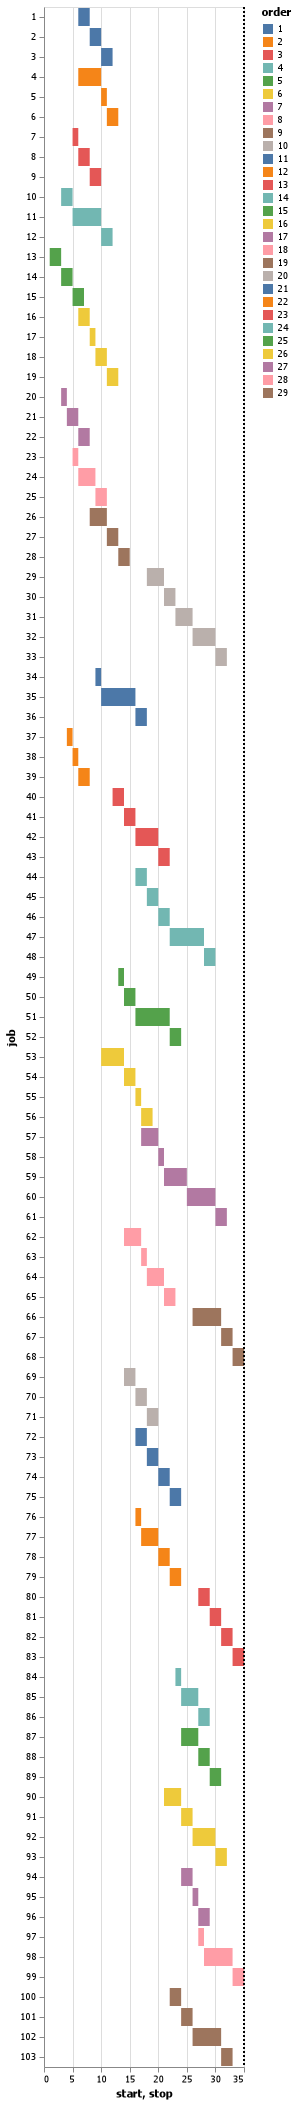

In [29]:
starts = state_at_time_t(starts_T, 35)
finishes = state_at_time_t(finish_T, 35)
O = newdata.Order
create_dynamic_gantt_chart(starts, finishes, I, O, 35)

In [19]:
#Compute complete resource load (all jobs, all timesteps)
load = workload_t(resource_load_T, RESCHEDULING_FREQ,T_F)

103-element Vector{Pair{Int64, Vector{Float64}}}:
   1 => [0.0, 0.0, 0.0, 2.9916245908202366, 2.9916245908202366, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
   2 => [0.0, 0.0, 0.0, 0.0, 0.0, 1.9980029374240638, 1.9980029374240638, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
   3 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28889181823955523, 0.28889181823955523, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
   4 => [0.0, 0.0, 0.0, -1.215819979450425e-13, 2.032425981636328, 2.032425981636328, 2.032425981636053, 2.0324259816361745, -1.8319000476553412e-13, -8.599911488666146e-14  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
   5 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.458474751765992, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
   6 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.351086024826486  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
   7 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [25]:
n_orders = N_order #Toimiii vielä kun jokaisessa tilauksessa on sama määrä (4) työtä...
#HUOM! Resurssit eivät tule nyt suoraan työn järjestyksestä tilauksessa!!!

res_nro1 = 7 #2-7
@assert(res_nro1 >= 2 && res_nro1 <= 7)
jobs_res1 = subset(newdata, :Resource_idx => ByRow(x -> x == res_nro1)).Job
vectr = Vector{Vector{Float64}}(undef, length(jobs_res1))
j = 1
for job in jobs_res1
    vectr[j] = load[job][2]
    j += 1
end
matriisi = vcat([vectr[i]' for i in 1:length(jobs_res1)]...)
load_sum = sum(matriisi, dims=1)
println(load_sum)
#capacity = [6, 6, 6, 8, 9, 2]

[0.0 0.0 0.0 0.0 0.4662895390187175 0.8360063018887012 1.4704690267205829 1.3896440820901546 0.28889181823955523 1.8930851302686145 1.8930851302686145 0.7917043070693075 0.7917043070693075 1.93137442087071 1.93137442087071 0.5813547619774405 1.686289016980906 1.2476742021687452 0.2698967787544174 0.729968276263622 0.6028114446744844 0.0 1.5712197052385957 1.5712197052385957 0.4330164901930441 0.6530448188878889 0.22002832869484476 0.2901092422763574 0.2901092422763574 0.6652358460488155 0.6652358460488155 1.088009895325824 1.621853192308279 0.5338432969824553 0.342833501815945 0.342833501815945 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


In [177]:
work_contents

1×6 Matrix{Float64}:
 102.059  142.701  27.9057  114.982  61.4578  29.0902

In [178]:
#TODO: TARKISTA ETTÄ KAIKKI RESURSSIEN KUORMIEN SUMMA == WORK CONTENTIT
work_contents = sum(WC, dims=1)
isapprox(work_contents[res_nro1-1], sum(load_sum))

true

In [4]:
#TODO: Calculate capacities based on data
jobdurations_res2 = ((subset(newdata, :Resource_idx => ByRow(x -> x == 2))).Duration)

max_dueduate_res2 = maximum((subset(newdata, :Resource_idx => ByRow(x -> x == 2))).Duedate)
wc_res2 = ((subset(newdata, :Resource_idx => ByRow(x -> x == 2))).job_WC)
durwc_dotprod = sum(jobdurations_res2 .* 24 .* wc_res2)
capacityres2 = 1.1111 * durwc_dotprod /(max_dueduate_res2 * 24) 
wc_res2

496-element Vector{Float64}:
  8.129703926544698
  1.7966583062413881
  3.6640604415379543
  5.6607442369420795
  6.894431319531683
  4.42703328816712
  2.7612796875497234
 10.556797495265474
  7.911228299601271
  6.709899709031979
 10.984604515436136
  3.1581016308990764
  3.5301104412524227
  ⋮
 11.173673666896741
  4.872872690850784
  3.409143722870481
  2.732367375188316
  5.057013348765107
  1.4696675638695205
  5.528189180572673
  8.41388812604016
  7.382463982227955
  5.466753525894979
  7.216779545555905
  9.259506983582384